<a href="https://colab.research.google.com/github/yueliyl/gec_intro2ml/blob/A1-(WIP)/Tutorial_1_GEC_academy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Machine Learning: Assignment 1
This tutorial will cover the basics of evaluating model performance. We will experiment with K-Nearest Neighbors (KNN) and Decision Tree (DT) models on the Iris benchmark dataset. The goal of this tutorial is to adapt the analysis to patient healthcare data used in the context of Assignment 1.

#Before running any code (if running on Google Colab)
Create a copy of the notebook by going to **File -> Save a copy in Drive**. This notebook can be accessed via Google Colab by clicking on the badge below:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mravanba/comp551-notebooks/blob/master/KNN.ipynb)

# Setup and data import

The first step in a Python analysis script is to import librairies. Here, we also set the random seed for reproducibility.

In [ ]:
import numpy as np
import pandas as pd
import time
import seaborn as sns

#the output of plotting commands is displayed inline within frontends
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from IPython.core.debugger import set_trace         #for debugging

#it is important to set the seed for reproducibility as it initializes the random number generator
np.random.seed(1234)

##Data processing and visualization

We conveniently load the dataset from the sklearn collection of datasets. In this notebook we use the Iris dataset.

In [ ]:
from sklearn import datasets
## to read more about load_iris() function refer to: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html
data, classes = datasets.load_iris(return_X_y=True, as_frame=True)

x = data.values[:,:2]
y = classes.values

We create the input matrix $X \in \mathbb{R}^{N \times D}$ and the output vector $y \in \{1,\ldots,C\}^N$.
Let's only use `sepal length` and `sepal width` for classification. We then randomly split the data into train and test and visualize the data.

instances (N) 	 150 
 features (D) 	 2 
 classes (C) 	 3


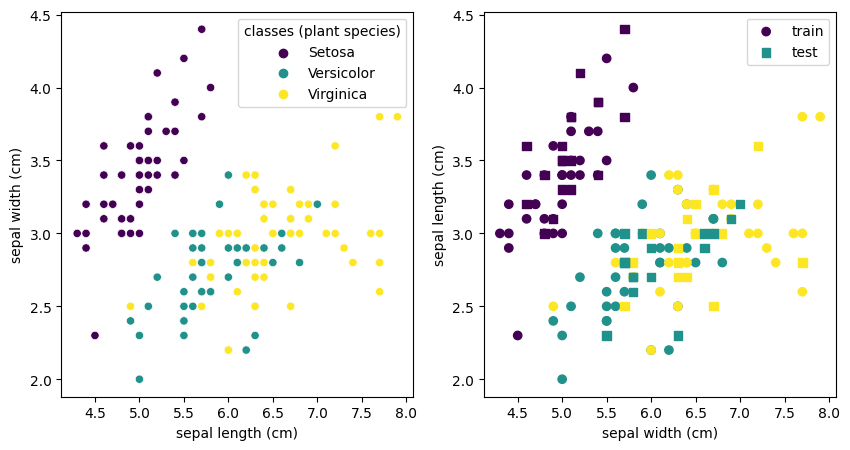

In [ ]:
## dataset['data'] and dataset['target'] are both numpy arrays
## dataset['data'] is (150, 4), and dataset['target'] is (150,)
#x, y = dataset['data'][:,:2], dataset['target'] #slices the first two columns or features from the data

## print the feature shape and classes of dataset
(N,D), C = x.shape, np.max(y)+1
print(f'instances (N) \t {N} \n features (D) \t {D} \n classes (C) \t {C}')

inds = np.random.permutation(N)      #generates an indices array from 0 to N-1 and permutes it

## split the dataset into train and test
x_train, y_train = x[inds[:100]], y[inds[:100]] # could alternatively use scikit-learn's train_test_split() function
x_test, y_test = x[inds[100:]], y[inds[100:]]

## visualization of the data
fig, ax = plt.subplots(1,2,figsize=[10.,5.])

class_index_to_name = {
    0: 'Setosa',
    1: 'Versicolor',
    2: 'Virginica'
}

class_names = classes.map(class_index_to_name)

# Get the first three colors from the 'viridis' colormap
viridis_colors = plt.get_cmap('viridis').colors
low_value_color = viridis_colors[0]
middle_value_color = viridis_colors[len(viridis_colors) // 2]
high_value_color = viridis_colors[-1]

# Convert the colors to RGBA format
low_value_rgba = mcolors.to_rgba(low_value_color)
middle_value_rgba = mcolors.to_rgba(middle_value_color)
high_value_rgba = mcolors.to_rgba(high_value_color)
class_palette = {'Setosa': low_value_rgba, 'Versicolor': middle_value_rgba, 'Virginica': high_value_rgba}

sns.scatterplot(data=data.iloc[:,:2], x='sepal length (cm)', y='sepal width (cm)', hue=class_names, palette=class_palette, ax=ax[0])
ax[0].legend(title='classes (plant species)')

ax[1].scatter(x_train[:,0], x_train[:,1], c=y_train, marker='o', label='train')
ax[1].scatter(x_test[:,0], x_test[:,1], c=y_test, marker='s', label='test')
ax[1].legend()
ax[1].set_ylabel('sepal length (cm)')
ax[1].set_xlabel('sepal width (cm)')

## save figure to drive
plt.savefig('iris.png', dpi=300)

# K-Nearest Neighbours
Our goal is to implement a K-NN classifier and apply it to classify the Iris dataset.

## The `KNN` class
We implement our models as python classes. Two class methods that we usually need to implement are `fit` and `predict`, which respectively perform training by fitting the data and make prediction on new data. The model is initialized with the `__init__` function, and serves to initialise class attributes. Notably, such attributes include model *hyperparameters*.

In [ ]:
#define the metric we will use to measure similarity
#if the input shapes are [1,N1,F] and [N2,1,F] then output shape is [N2,N1]
#as numpy supports broadcasting with arithmetic operations
#for more on numpy broadcasting refer to: https://numpy.org/doc/stable/user/basics.broadcasting.html
euclidean = lambda x1, x2: np.sqrt(np.sum((x1 - x2)**2, axis=-1))
manhattan = lambda x1, x2: np.sum(np.abs(x1 - x2), axis=-1)

class KNN:

    def __init__(self, K=1, dist_fn= euclidean):
        self.dist_fn = dist_fn
        self.K = K
        return

    def fit(self, x, y):
        ''' Store the training data using this method as it is a lazy learner'''
        self.x = x
        self.y = y
        self.C = np.max(y) + 1
        return self

    def predict(self, x_test):
        ''' Makes a prediction using the stored training data and the test data given as argument'''
        num_test = x_test.shape[0]
        # calculate distance between the training & test samples and returns an array of shape [num_test, num_train]
        # self.x is in shape (100, 2), x_test is in shape (50, 2)
        # self.x[None, :, :] is in shape (1, 100, 2), and x_test[:,None,:] is in shape (50, 1, 2)
        # result: (x_test.shape[0], self.x.shape[0])
        distances = self.dist_fn(self.x[None,:,:], x_test[:,None,:])
        #ith-row of knns stores the indices of k closest training samples to the ith-test sample
        knns = np.zeros((num_test, self.K), dtype=int)
        #ith-row of y_prob has the probability distribution over C classes
        y_prob = np.zeros((num_test, self.C))
        for i in range(num_test):
            # print(i)
            knns[i,:] = np.argsort(distances[i])[:self.K]
            # print(knns[i,:])
            y_prob[i,:] = np.bincount(self.y[knns[i,:]], minlength=self.C) #counts the number of instances of each class in the K-closest training samples
        #y_prob /= np.sum(y_prob, axis=-1, keepdims=True)
        #simply divide by K to get a probability distribution
        y_prob /= self.K
        return y_prob, knns

We next `fit` the model and make a prediction on test set using `predict`. We further connect each test node to its closest nearest neighbors in the plot.

knns shape: (50, 1)
y_prob shape: (50, 3)
accuracy is 72.0.


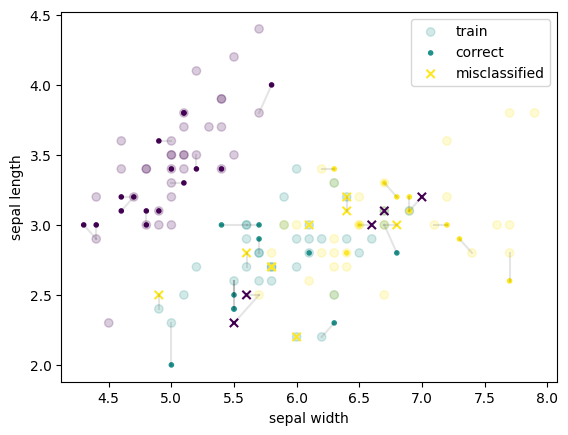

In [ ]:
myK = 1

model = KNN(K=myK)

y_prob, knns = model.fit(x_train, y_train).predict(x_test)
print('knns shape:', knns.shape)
print('y_prob shape:', y_prob.shape)

#To get hard predictions by choosing the class with the maximum probability
y_pred = np.argmax(y_prob, axis=-1)
accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
print(f'accuracy is {accuracy*100:.1f}.')

#boolean array to later slice the indexes of correct and incorrect predictions
correct = y_test == y_pred
incorrect = np.logical_not(correct)

#visualization of the points
plt.scatter(x_train[:,0], x_train[:,1], c=y_train, marker='o', alpha=.2, label='train')
plt.scatter(x_test[correct,0], x_test[correct,1], marker='.', c=y_pred[correct], label='correct')
plt.scatter(x_test[incorrect,0], x_test[incorrect,1], marker='x', c=y_test[incorrect], label='misclassified')

#connect each node to k-nearest neighbours in the training set
for i in range(x_test.shape[0]):
    for k in range(model.K):
        hor = x_test[i,0], x_train[knns[i,k],0]
        ver = x_test[i,1], x_train[knns[i,k],1]
        plt.plot(hor, ver, 'k-', alpha=.1)

plt.ylabel('sepal length')
plt.xlabel('sepal width')
plt.legend()
plt.savefig('iris_KNN'+str(myK)+'.png',dpi=300,bbox_inches='tight')
# plt.show()

## Decision Boundaries
To draw the decision boundary we classify all the points on a 2D grid. The `meshgrid` function creates all the points on the grid by taking discretizations of horizontal and vertical axes.

In [ ]:
y_train

array([1, 1, 2, 0, 1, 0, 0, 0, 1, 2, 1, 0, 2, 1, 0, 1, 2, 0, 2, 1, 1, 1,
       1, 1, 2, 0, 2, 1, 2, 0, 1, 2, 0, 2, 1, 0, 0, 0, 0, 1, 0, 1, 0, 2,
       2, 0, 2, 2, 2, 2, 0, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 2, 2, 2, 0, 0,
       0, 2, 1, 2, 2, 1, 0, 2, 0, 2, 0, 1, 1, 0, 1, 0, 2, 2, 2, 1, 0, 0,
       2, 1, 1, 0, 1, 2, 1, 1, 1, 0, 0, 0])

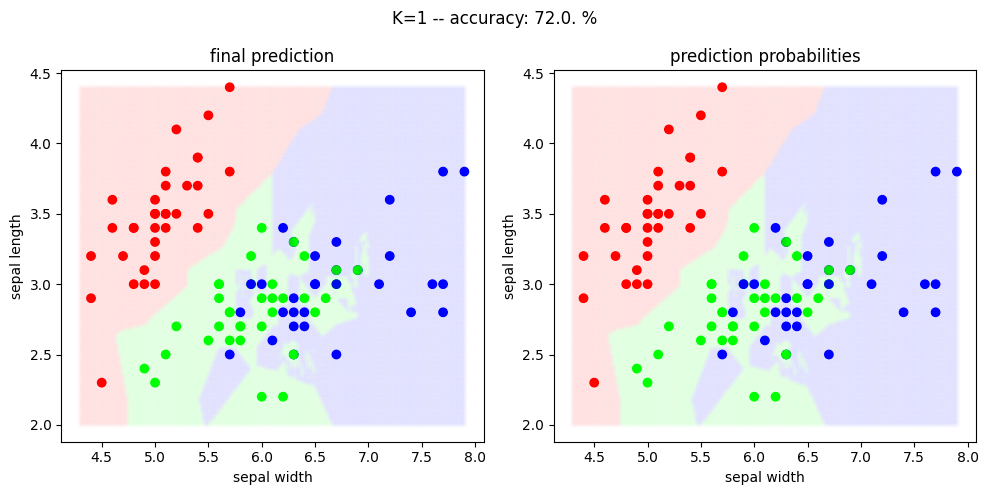

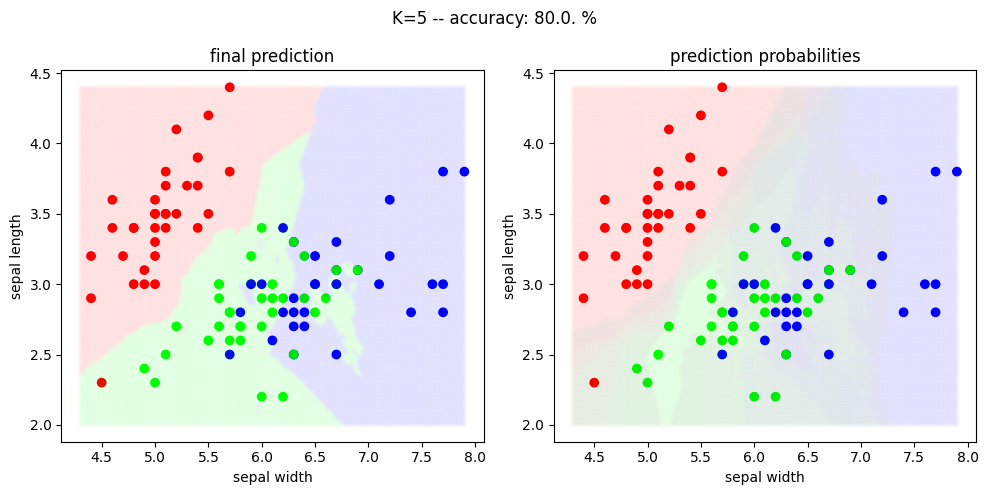

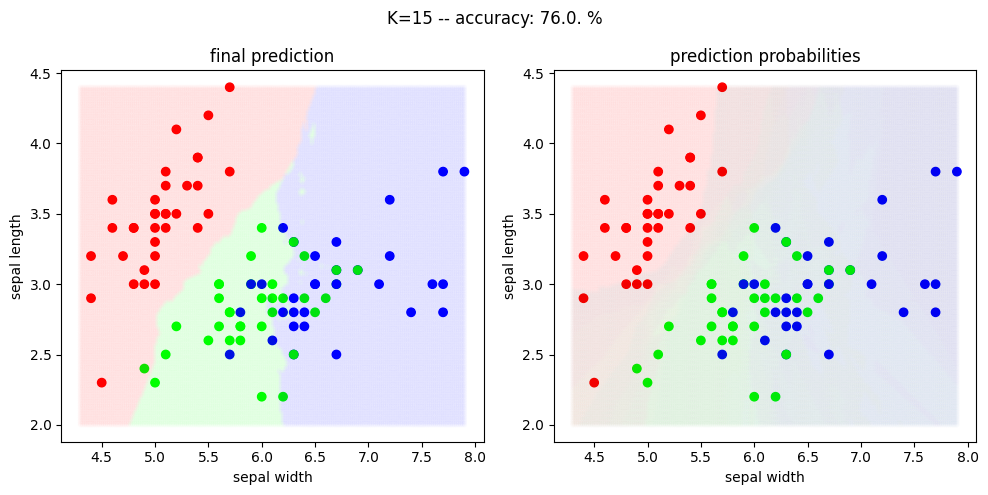

In [ ]:
#we can make the grid finer by increasing the number of samples from 200 to higher value
x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 200)
x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 200)

# to features values as a mesh
x0, x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

for k in [1, 5, 15]:

    model = KNN(K=k)

    y_train_prob = np.zeros((y_train.shape[0], C))
    y_train_prob[np.arange(y_train.shape[0]), y_train] = 1

    y_prob, knns = model.fit(x_train, y_train).predict(x_test)
    y_pred = np.argmax(y_prob,axis=-1)
    y_pred_onehot  = pd.get_dummies(y_pred).values
    y_train_onehot = pd.get_dummies(y_train).values

    correct = y_test == y_pred
    incorrect = np.logical_not(correct)

    accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
    acc = f'accuracy: {accuracy*100:.1f}.'

    ## to get class probability of all the points in the 2D grid
    y_prob_all, _ = model.fit(x_train, y_train).predict(x_all)

    y_pred_all = np.zeros_like(y_prob_all)
    y_pred_all[np.arange(x_all.shape[0]), np.argmax(y_prob_all, axis=-1)] = 1

    ## plot decision boundaries
    fig, ax = plt.subplots(1,2,figsize=[10.,5.])

    ## decision boundaries wrt final prediction
    ax[0].set_title('final prediction')
    ax[0].scatter(x_train[:,0], x_train[:,1], c=y_train_onehot, marker='o', alpha=1)
    ax[0].scatter(x_all[:,0], x_all[:,1], c=y_pred_all, marker='.', alpha=.01)
    ax[0].set_ylabel('sepal length')
    ax[0].set_xlabel('sepal width')

    ## decision boundaries wrt prediction probabilites
    ax[1].set_title('prediction probabilities')
    ax[1].scatter(x_train[:,0], x_train[:,1], c=y_train_prob, marker='o', alpha=1)
    ax[1].scatter(x_all[:,0], x_all[:,1], c=y_prob_all, marker='.', alpha=.01)
    ax[1].set_ylabel('sepal length')
    ax[1].set_xlabel('sepal width')

    fig.suptitle(f'K={k} -- {acc} %')
    fig.tight_layout(); fig.show()


## Choosing hyperparameter K in KNN

We further split the training data into 50% training and 50% validation to choose the hyperparameter K.

In [ ]:
from sklearn.model_selection import train_test_split

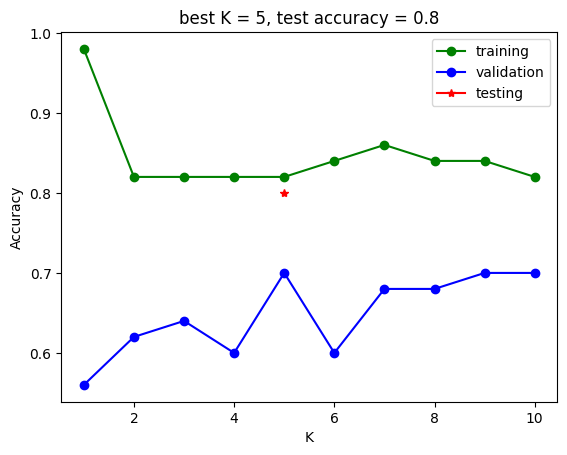

In [ ]:
# further split the training data into 50% training and 50% validation
x_train_tr, x_train_va, y_train_tr, y_train_va = \
  train_test_split(x_train, y_train, test_size=0.5, random_state=42)

model_choices=[]
train_accs, valid_accs = ([],[])

n_valid = y_train_va.shape[0]
model_choices = np.arange(1,11)

for k in model_choices:

    ## intialise KNN model
    knn = KNN(K=k)

    ## make predictions on training data
    y_train_tr_prob,_ = knn.fit(x_train_tr, y_train_tr).predict(x_train_tr)
    y_train_tr_pred = y_train_tr_prob.argmax(axis=-1)

    ## make predictions on validation data
    y_train_va_prob,_ = knn.predict(x_train_va)
    y_train_va_pred = y_train_va_prob.argmax(axis=-1)

    ## obtain training and validation classification accuracies
    train_acc = np.sum(y_train_tr_pred == y_train_tr)/n_valid
    valid_acc = np.sum(y_train_va_pred == y_train_va)/n_valid

    ## store accuracies in lists for later use
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)


## find the best hyperparameter value K and initialise KNN model
best_valid_K = model_choices[valid_accs.index(max(valid_accs))]
knn = KNN(K=best_valid_K)

## make prediction on testing data, only for best KNN model
y_test_prob,_ = knn.fit(x_train, y_train).predict(x_test)
y_test_pred = np.argmax(y_test_prob, axis=-1)

## obtain testing accuracy
test_accuracy = np.sum(y_test_pred == y_test)/y_test.shape[0]

## plot training, validation and testing accuracies
plt.plot(model_choices, train_accs, marker='o', color='green', label='training')
plt.plot(model_choices, valid_accs, marker='o', color='blue', label='validation')
plt.plot(best_valid_K, test_accuracy, marker='*', color='red', label='testing')

plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.title(f'best K = {best_valid_K}, test accuracy = {test_accuracy}')
plt.show()

## KNN is sensitive to feature scaling

accuracy is 72.0.


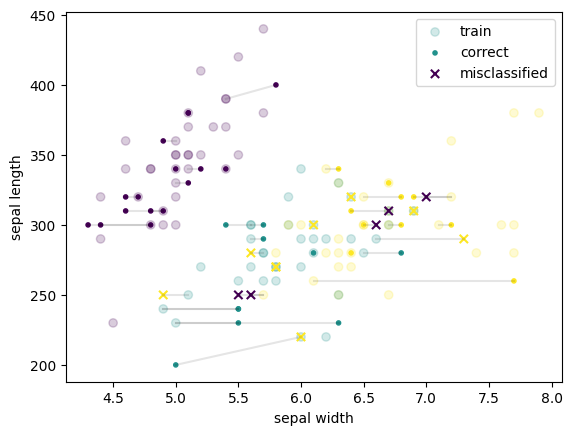

In [ ]:
myK = 1

model = KNN(K=myK)

x_train_mod = x_train.copy()
x_test_mod = x_test.copy()

feature_id = 1 # feature to scale

x_train_mod[:,feature_id] = x_train_mod[:,feature_id] * 100
x_test_mod[:,feature_id] = x_test_mod[:,feature_id] * 100

y_prob, knns = model.fit(x_train_mod, y_train).predict(x_test_mod)

#To get hard predictions by choosing the class with the maximum probability
y_pred = np.argmax(y_prob,axis=-1)
accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
print(f'accuracy is {accuracy*100:.1f}.')

#boolean array to later slice the indexes of correct and incorrect predictions
correct = y_test == y_pred
incorrect = np.logical_not(correct)

#visualization of the points
plt.scatter(x_train_mod[:,0], x_train_mod[:,1], c=y_train, marker='o', alpha=.2, label='train')
plt.scatter(x_test_mod[correct,0], x_test_mod[correct,1], marker='.', c=y_pred[correct], label='correct')
plt.scatter(x_test_mod[incorrect,0], x_test_mod[incorrect,1], marker='x', c=y_test[incorrect], label='misclassified')

#connect each node to k-nearest neighbours in the training set
for i in range(x_test_mod.shape[0]):
    for k in range(model.K):
        hor = x_test_mod[i,0], x_train_mod[knns[i,k],0]
        ver = x_test_mod[i,1], x_train_mod[knns[i,k],1]
        plt.plot(hor, ver, 'k-', alpha=.1)

plt.ylabel('sepal length')
plt.xlabel('sepal width')
plt.legend()
plt.savefig('iris_KNN'+str(myK)+'_scaledX'+str(feature_id)+'.png',dpi=300, bbox_inches='tight')
# plt.show()

## Standardizing features

Text(0.5, 0, 'sepal width')

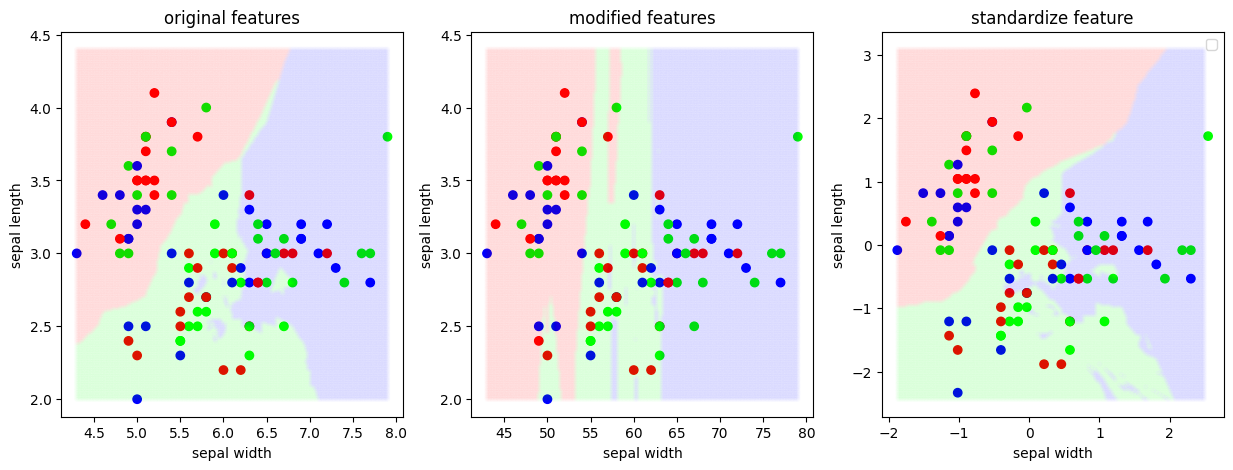

In [ ]:
model = KNN(K=5)

x_train_mod = x_train.copy()
x_test_mod = x_test.copy()
x_mod = x.copy()

x_train_mod[:,0] = x_train_mod[:,0] * 10
x_test_mod[:,0]  = x_test_mod[:,0] * 10
x_mod[:,0] = x_mod[:,0] * 10

#we can make the grid finer by increasing the number of samples from 200 to higher value
x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 200)
x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 200)
x0, x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

x0v_mod = np.linspace(np.min(x_mod[:,0]), np.max(x_mod[:,0]), 200)
x1v_mod = np.linspace(np.min(x_mod[:,1]), np.max(x_mod[:,1]), 200)
x0_mod, x1_mod = np.meshgrid(x0v_mod, x1v_mod)
x_all_mod = np.vstack((x0_mod.ravel(),x1_mod.ravel())).T

## make predictions on both original features and standardized features
y_prob    , _ = model.fit(x_train    , y_train).predict(x_test)
y_prob_mod, _ = model.fit(x_train_mod, y_train).predict(x_test_mod)
y_prob_all    , _ = model.fit(x_train,     y_train).predict(x_all)
y_prob_all_mod, _ = model.fit(x_train_mod, y_train).predict(x_all_mod)

#To get hard predictions by choosing the class with the maximum probability
y_pred     = y_prob.argmax(-1)
y_pred_mod = y_prob_mod.argmax(-1)
y_pred_all = y_prob_all.argmax(-1)
y_pred_all_mod = y_prob_all_mod.argmax(-1)

y_pred_onehot     = pd.get_dummies(y_pred).values
y_pred_mod_onehot = pd.get_dummies(y_pred_mod).values
y_pred_all_onehot = pd.get_dummies(y_pred_all).values
y_pred_all_onehot_mod = pd.get_dummies(y_pred_all_mod).values
y_train_ohehot    = pd.get_dummies(y_train).values

accuracy     = np.sum(y_pred     == y_test)/y_test.shape[0]
accuracy_mod = np.sum(y_pred_mod == y_test)/y_test.shape[0]
#print(f'accuracy is {accuracy*100:.1f}.')

fig, ax = plt.subplots(1,3,figsize=[15.,5.])

##
ax[0].set_title('original features')
ax[0].scatter(x_train[:,0], x_train[:,1], c=y_train_onehot, marker='o', alpha=1)
ax[0].scatter(x_all[:,0], x_all[:,1], c=y_pred_all_onehot, marker='.', alpha=.01)
ax[0].set_ylabel('sepal length')
ax[0].set_xlabel('sepal width')

##
ax[1].set_title('modified features')
ax[1].scatter(x_train_mod[:,0], x_train_mod[:,1], c=y_train_onehot, marker='o', alpha=1)
ax[1].scatter(x_all_mod[:,0], x_all_mod[:,1], c=y_pred_all_onehot_mod, marker='.', alpha=.01)
ax[1].set_ylabel('sepal length')
ax[1].set_xlabel('sepal width')

plt.legend()
# plt.show()

for d in range(x_train.shape[1]):
    x_train_mod[:,d] = (x_train_mod[:,d] - x_train_mod[:,d].mean())/x_train_mod[:,d].std()
    x_test_mod[:,d] = (x_test_mod[:,d] - x_test_mod[:,d].mean())/x_test_mod[:,d].std()
    x_mod[:,d] = (x_mod[:,d] - x_mod[:,d].mean())/x_mod[:,d].std()

x0v_mod = np.linspace(np.min(x_mod[:,0]), np.max(x_mod[:,0]), 200)
x1v_mod = np.linspace(np.min(x_mod[:,1]), np.max(x_mod[:,1]), 200)
x0_mod, x1_mod = np.meshgrid(x0v_mod, x1v_mod)
x_all_mod = np.vstack((x0_mod.ravel(),x1_mod.ravel())).T

## make predictions on both original features and standardized features
y_prob_mod, _ = model.fit(x_train_mod, y_train).predict(x_test_mod)
y_prob_all_mod, _ = model.fit(x_train_mod, y_train).predict(x_all_mod)

#To get hard predictions by choosing the class with the maximum probability
y_pred_mod = y_prob_mod.argmax(-1)
y_pred_all_mod = y_prob_all_mod.argmax(-1)

y_pred_mod_onehot = pd.get_dummies(y_pred_mod).values
y_pred_all_onehot_mod = pd.get_dummies(y_pred_all_mod).values

accuracy_mod = np.sum(y_pred_mod == y_test)/y_test.shape[0]

ax[2].set_title('standardize feature')
ax[2].scatter(x_train_mod[:,0], x_train_mod[:,1], c=y_train_onehot, marker='o', alpha=1)
ax[2].scatter(x_all_mod[:,0], x_all_mod[:,1], c=y_pred_all_onehot_mod, marker='.', alpha=.01)
ax[2].set_ylabel('sepal length')
ax[2].set_xlabel('sepal width')

## The Effect of Noise and Feature Scaling
Nearest neighbours are highly affected by the existence of noisy or irrelevant features.
Lets add noise and see how it affects the accuracy of our classifier.

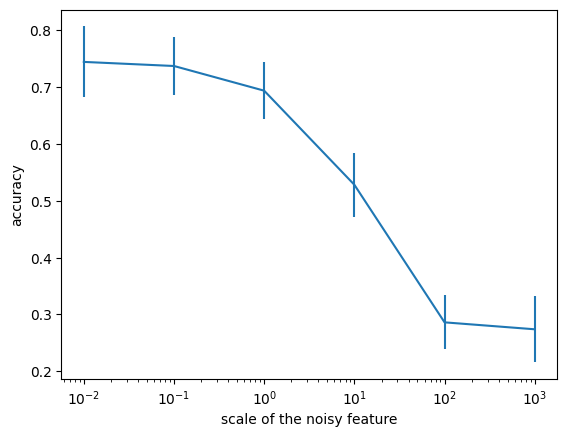

In [ ]:
noise_scale = [.01, .1, 1, 10, 100, 1000]

## generate random noise
noise = np.random.randn(x.shape[0],1)
results = []
for s in noise_scale:
    ## add noise as an extra feature
    x_n = np.column_stack((x, noise*s))
    results.append([])

    ##repeat the experiment 100 times with different train and test split
    for r in range(100):
        ## data processing and train-test split
        inds = np.random.permutation(N)
        x_train, y_train = x_n[inds[:100]], y[inds[:100]]
        x_test, y_test = x_n[inds[100:]], y[inds[100:]]

        ## define model
        model = KNN(K=3)

        ## prediction
        y_prob, _ = model.fit(x_train, y_train).predict(x_test)
        y_pred = np.argmax(y_prob,1)
        accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
        results[-1].append(accuracy)

results = np.array(results)
plt.errorbar(noise_scale, results.mean(1), results.std(1))
plt.xscale('log')
plt.xlabel("scale of the noisy feature")
plt.ylabel("accuracy")
plt.show()

As we increase the noise level of spurious features, these features dominate distance calculattions such that the K nearest neighbors are more affected by the spurious features rather than the relevant ones.

# Decision Tree (DT)
We implement a decision tree for classification from scratch. We first define a data-structure to represent nodes, then we define a function to pick the best *test* for a node based on a *cost function*. Starting from the root node, we use this test function recursively to find the best split until a *max-depth* is reached.

## Greedy spliting of a node
Given a node, we consider all possible feature-value combinations for splitting the data. One such **test** that produces the lowest cost according to a supplied cost function (`cost_fn`) is returned.

In [ ]:
def greedy_test(node, cost_fn):
    ## initialize the best parameter values
    best_cost = np.inf
    best_feature, best_value = None, None
    num_instances, num_features = node.data.shape

    ## sort the features to get the test value candidates by taking the average of consecutive sorted feature values
    data_sorted = np.sort(node.data[node.data_indices],axis=0)
    test_candidates = (data_sorted[1:] + data_sorted[:-1]) / 2.
    for f in range(num_features):
        ##stores the data corresponding to the f-th feature
        data_f = node.data[node.data_indices, f]

        for test in test_candidates[:,f]:
            ## Split the indices using the test value of f-th feature
            left_indices = node.data_indices[data_f <= test]
            right_indices = node.data_indices[data_f > test]
            #we can't have a split where a child has zero element
            #if this is true over all the test features and their test values  then the function returns the best cost as infinity
            if len(left_indices) == 0 or len(right_indices) == 0:
                continue

            ## compute the left and right cost based on the current split
            left_cost = cost_fn(node.labels[left_indices])
            right_cost = cost_fn(node.labels[right_indices])
            num_left, num_right = left_indices.shape[0], right_indices.shape[0]

            ## get the combined cost using the weighted sum of left and right cost
            cost = (num_left * left_cost + num_right * right_cost)/num_instances

            ## update only when a lower cost is encountered
            if cost < best_cost:
                best_cost = cost
                best_feature = f
                best_value = test

    return best_cost, best_feature, best_value

## Data structure
We use a binary tree to assign information to the nodes of the decision tree. In particular, the instances associated with that node (`data_indices`) and the test that is used to further split that node, in the case non-leaf nodes (`split_feature, split_value`). Here, we assume each test involves a single feature, and all features are real-valued.

In [ ]:
class Node:
    def __init__(self, data_indices, parent):
        self.data_indices = data_indices                    #stores the data indices which are in the region defined by this node
        self.left = None                                    #stores the left child of the node
        self.right = None                                   #stores the right child of the node
        self.split_feature = None                           #the feature for split at this node
        self.split_value = None                             #the value of the feature for split at this node
        if parent:
            self.depth = parent.depth + 1                   #obtain the dept of the node by adding one to dept of the parent
            self.num_classes = parent.num_classes           #copies the num classes from the parent
            self.data = parent.data                         #copies the data from the parent
            self.labels = parent.labels                     #copies the labels from the parent
            class_prob = np.bincount(self.labels[data_indices], minlength=self.num_classes) #this is counting frequency of different labels in the region defined by this node
            self.class_prob = class_prob / np.sum(class_prob)  #stores the class probability for the node
            #note that we'll use the class probabilites of the leaf nodes for making predictions after the tree is built

## Cost functions

Below we implement two cost functions corresponding to misclassification rate and entropy.

In [ ]:
## computes misclassification cost by subtracting the maximum probability of any class
def cost_misclassification(labels):
    counts = np.bincount(labels)
    class_probs = counts / np.sum(counts)
    return 1 - np.max(class_probs)

## computes entropy of the labels by computing the class probabilities
def cost_entropy(labels):
    class_probs = np.bincount(labels) / len(labels)
    class_probs = class_probs[class_probs > 0]              #this steps is remove 0 probabilities for removing numerical issues while computing log
    return -np.sum(class_probs * np.log2(class_probs))       #expression for entropy -\sigma p(x)log[p(x)]

## computes the gini index cost
def cost_gini_index(labels):
    class_probs = np.bincount(labels) / len(labels)
    return 1 - np.sum(np.square(class_probs))               #expression for gini index 1-\sigma p(x)^2

### Comparison of the 3 cost functions for binary class

Entropy and Gini index behave similarly.

<Figure size 640x480 with 0 Axes>

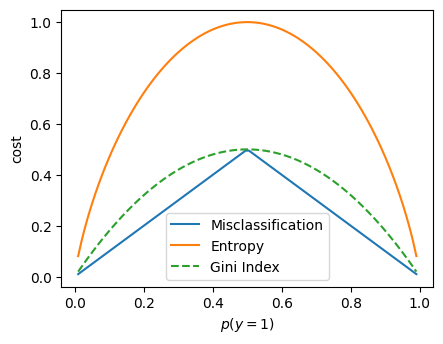

In [ ]:
x = np.linspace(0.01, 0.99, 100)
f1 = 1 - np.max(np.stack((x, 1-x)),axis=0)
f2 = -x * np.log2(x) - (1-x) * np.log2(1-x)
f3 = 2 * x * (1 - x)

plt.clf()
plt.figure(figsize=(4.8, 3.6))
plt.plot(x, f1, "-", label="Misclassification")
plt.plot(x, f2, "-", label="Entropy")
plt.plot(x, f3, "--", label="Gini Index")
plt.xlabel("$p(y=1)$")
plt.ylabel("cost")
plt.legend()

we are now ready to implement the classifier:

when to stop splitting?
1. if there are not enough points under the current node (`min_leaf_instances`)
2. if maximum depth has been reached (`max_depth`)
3. if the decrease in the cost is negligible (not implemented)

Below is a template of the `DecisionTree` class. We next implement `fit` and `predict` methods.

In [ ]:
class DecisionTree:
    def __init__(self, num_classes=None, max_depth=3, cost_fn=cost_misclassification, min_leaf_instances=1):
        self.max_depth = max_depth      #maximum dept for termination
        self.root = None                #stores the root of the decision tree
        self.cost_fn = cost_fn          #stores the cost function of the decision tree
        self.num_classes = num_classes  #stores the total number of classes
        self.min_leaf_instances = min_leaf_instances  #minimum number of instances in a leaf for termination

    def fit(self, data, labels):
        pass                            #pass in python 3 means nothing happens and the method here is empty

    def predict(self, data_test):
        pass

## Fit
To fit the tree to the data, we call the `_fit_tree` method on the `root_node` of the tree. In this method the _best_ test (split) for the current node is found, and the method is recursively called on the left and right child. If the `max_depth` is reached or the number of instances under the current node is below `min_leaf_instances` the node is not split anymore, resulting in a leaf node.

In [ ]:
def fit(self, data, labels):
    self.data = data
    self.labels = labels
    if self.num_classes is None:
        self.num_classes = np.max(labels) + 1

    ## below are initialization of the root of the decision tree
    self.root = Node(np.arange(data.shape[0]), None)
    self.root.data = data
    self.root.labels = labels
    self.root.num_classes = self.num_classes
    self.root.depth = 0

    ## to recursively build the rest of the tree
    self._fit_tree(self.root)
    return self

def _fit_tree(self, node):
    ## This gives the condition for termination of the recursion resulting in a leaf node
    if node.depth == self.max_depth or len(node.data_indices) <= self.min_leaf_instances:
        return

    ## greedily select the best test by minimizing the cost
    cost, split_feature, split_value = greedy_test(node, self.cost_fn)

    ## if the cost returned is infinity it means that it is not possible to split the node and hence terminate
    if np.isinf(cost):
        return
    #print(f'best feature: {split_feature}, value {split_value}, cost {cost}')

    ## to get a boolean array suggesting which data indices corresponding to this node are in the left of the split
    test = node.data[node.data_indices,split_feature] <= split_value

    ## store the split feature and value of the node
    node.split_feature = split_feature
    node.split_value = split_value

    ##define new nodes which are going to be the left and right child of the present node
    left = Node(node.data_indices[test], node)
    right = Node(node.data_indices[np.logical_not(test)], node)

    ## recursive call to the _fit_tree()
    self._fit_tree(left)
    self._fit_tree(right)

    ## assign the left and right child to present child
    node.left = left
    node.right = right

## assign class fitting methods
DecisionTree.fit = fit
DecisionTree._fit_tree = _fit_tree

## New predictions
Given a new instance, we start from the `root` of the `DecisionTree` and check whether the instance falls in the left or right split. The process is repeated at the left or right node depending on the test, until a leaf node is reached. The class probabilities of the training data under the leaf is returned.

In [ ]:
def predict(self, data_test):
    class_probs = np.zeros((data_test.shape[0], self.num_classes))
    for n, x in enumerate(data_test):
        node = self.root

        ## loop along the dept of the tree looking region where the present data sample fall in based on the split feature and value
        while node.left:
            if x[node.split_feature] <= node.split_value:
                node = node.left
            else:
                node = node.right

        ## the loop terminates when you reach a leaf of the tree and the class probability of that node is taken for prediction
        class_probs[n,:] = node.class_prob

    return class_probs

## assign class prediction method
DecisionTree.predict = predict

## Experiments
We will experiment on the same Iris dataset as we did when exploring the KNN model.

In [ ]:
dataset = datasets.load_iris()
x, y = dataset['data'][:,:2], dataset['target']
(num_instances, num_features), num_classes = x.shape, np.max(y)+1

inds = np.random.permutation(num_instances)
x_train, y_train = x[inds[:100]], y[inds[:100]]
x_test, y_test = x[inds[100:]], y[inds[100:]]

We now fit the `DecisionTree` on training data and predict on testing data.

accuracy is 64.0.


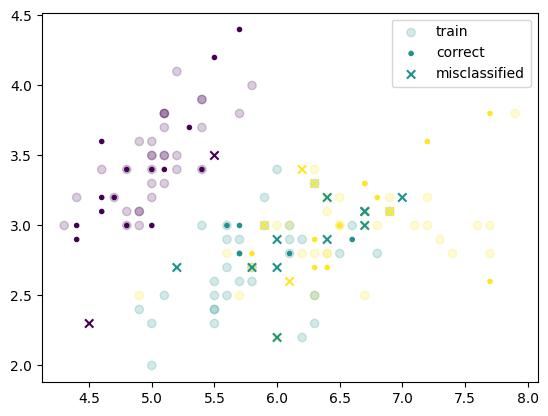

In [ ]:
tree = DecisionTree(max_depth=20)
probs_test = tree.fit(x_train, y_train).predict(x_test)
y_pred = np.argmax(probs_test,1)
accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
print(f'accuracy is {accuracy*100:.1f}.')

## visualize classifications
correct = y_test == y_pred
incorrect = np.logical_not(correct)
plt.scatter(x_train[:,0], x_train[:,1], c=y_train, marker='o', alpha=.2, label='train')
plt.scatter(x_test[correct,0], x_test[correct,1], marker='.', c=y_pred[correct], label='correct')
plt.scatter(x_test[incorrect,0], x_test[incorrect,1], marker='x', c=y_test[incorrect], label='misclassified')
plt.legend()
plt.show()

We now plot the decision boundary

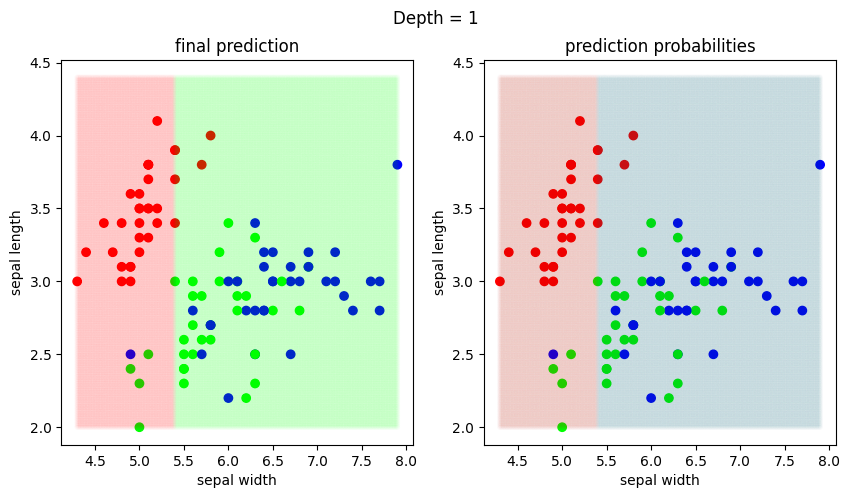

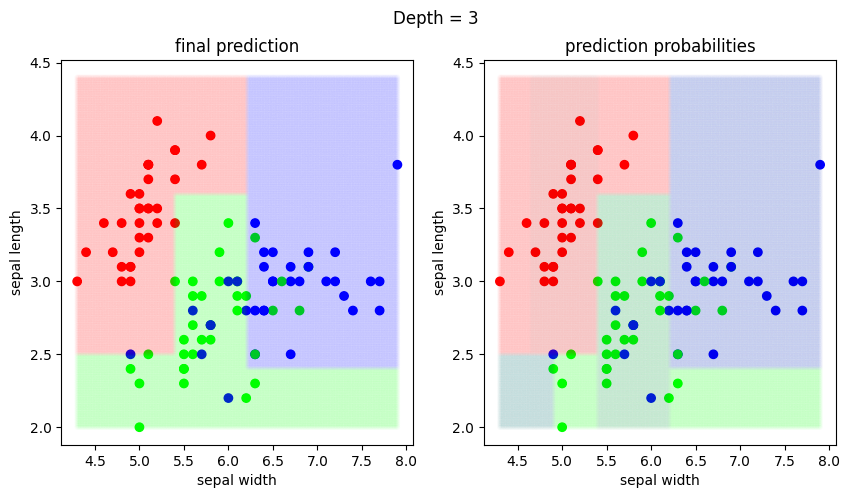

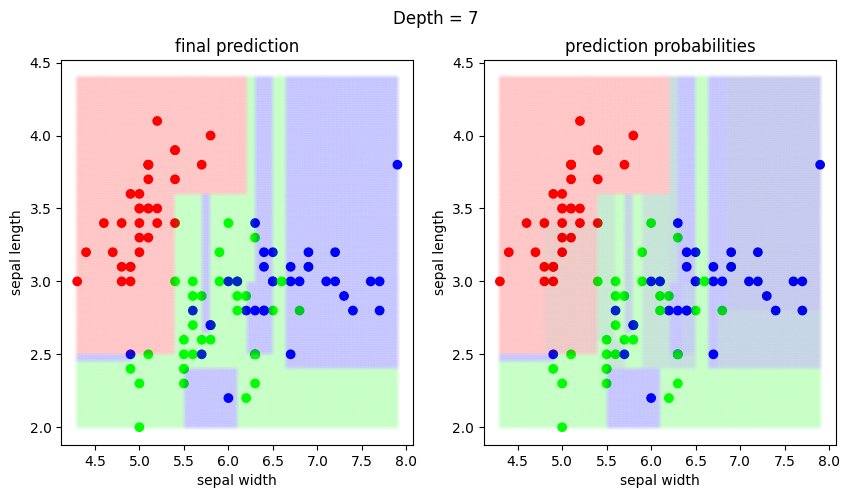

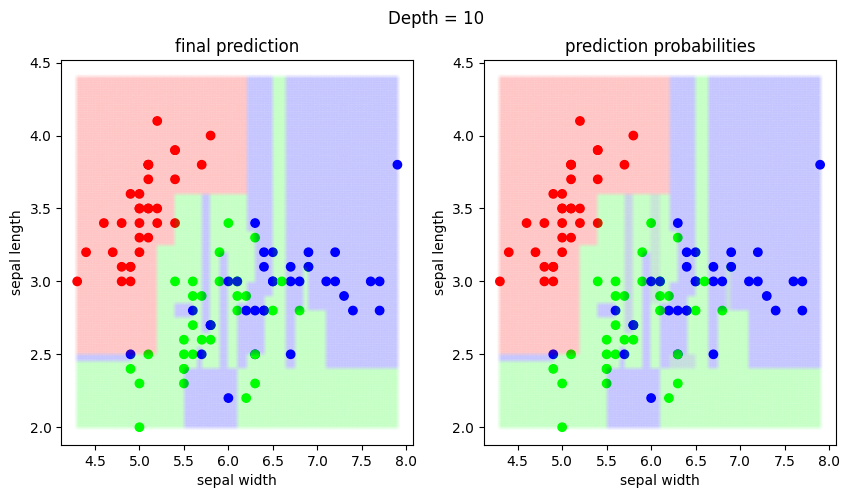

In [ ]:
## create 2D grid
x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 200)
x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 200)
x0,x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

y_train_onehot = pd.get_dummies(y_train).values

## loop through different tree depths (hyperparameter)
for tree_depth in [1,3,7,10]:

    ## initialise DT model
    model = DecisionTree(max_depth=tree_depth)

    ## make prediction
    y_prob_all = model.fit(x_train, y_train).predict(x_all)
    y_pred_all = y_prob_all.argmax(-1)

    ## one-hot encode, ensuring that all classes are included in the encoding
    y_pred_all_onehot = pd.get_dummies(y_pred_all)
    classes = np.arange(y.max()+1)
    class_not_in_columns = np.where(~np.isin(classes, y_pred_all_onehot.columns.tolist()))[0]
    y_pred_all_onehot[class_not_in_columns] = 0
    y_pred_all_onehot.reindex(columns=classes)
    y_pred_all_onehot = y_pred_all_onehot.values

    fig, ax = plt.subplots(1,2,figsize=[10.,5.])

    ax[0].set_title('final prediction')
    ax[0].scatter(x_train[:,0], x_train[:,1], c=y_train_onehot, marker='o', alpha=1)
    ax[0].scatter(x_all[:,0], x_all[:,1], c=y_pred_all_onehot, marker='.', alpha=.02)
    ax[0].set_ylabel('sepal length')
    ax[0].set_xlabel('sepal width')

    ax[1].set_title('prediction probabilities')
    ax[1].scatter(x_train[:,0], x_train[:,1], c=y_train_onehot, marker='o', alpha=1)
    ax[1].scatter(x_all[:,0], x_all[:,1], c=y_prob_all, marker='.', alpha=.02)
    ax[1].set_ylabel('sepal length')
    ax[1].set_xlabel('sepal width')

    fig.suptitle('Depth = ' + str(tree_depth))
    fig.show()

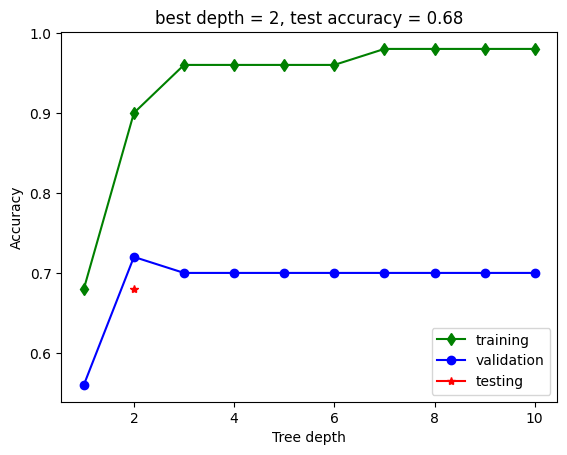

In [ ]:
# further split the training data into 50% training and 50% validation
X_train_tr, y_train_tr = x_train[:50], y_train[:50]
X_train_va, y_train_va = x_train[50:], y_train[50:]

model_choices=[]
train_acc = []
valid_acc = []

n_train = y_train_tr.shape[0]
n_valid = y_train_va.shape[0]

for k in range(1, 11):
    dt = DecisionTree(max_depth=k) # create a KNN object (OOP)

    y_train_tr_prob = dt.fit(X_train_tr, y_train_tr).predict(X_train_tr)
    y_train_tr_pred = np.argmax(y_train_tr_prob, axis=-1)
    acc_tr = np.sum(y_train_tr_pred == y_train_tr)/n_train

    y_train_va_prob = dt.fit(X_train_tr, y_train_tr).predict(X_train_va)
    y_train_va_pred = np.argmax(y_train_va_prob, axis=-1)
    acc_va = np.sum(y_train_va_pred == y_train_va)/n_valid

    model_choices.append(k)
    train_acc.append(acc_tr)
    valid_acc.append(acc_va)

# use the best K to predict test data
best_depth = model_choices[valid_acc.index(max(valid_acc))]
dt = DecisionTree(max_depth=best_depth)
y_test_prob = dt.fit(x_train, y_train).predict(x_test)
y_test_pred = np.argmax(y_test_prob, axis=-1)
test_accuracy = np.sum(y_test_pred == y_test)/y_test.shape[0]

plt.plot(model_choices, train_acc, marker='d', color='green', label='training')
plt.plot(model_choices, valid_acc, marker='o', color='blue', label='validation')
plt.plot(best_depth, test_accuracy, marker='*', color='red', label='testing')

plt.title(f'best depth = {best_depth}, test accuracy = {test_accuracy}')
plt.xlabel("Tree depth")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

# Model Evaluation and Selection

## True/false positive rates

True negative (TN)
* Negative example that is predicted to be negative

False positive (FP)
* Negative example that is predicted to be positive

False negative (FN)
* Positive example that is predicted to be negative

True positive (TP)
* Positive example that is predicted to be positive

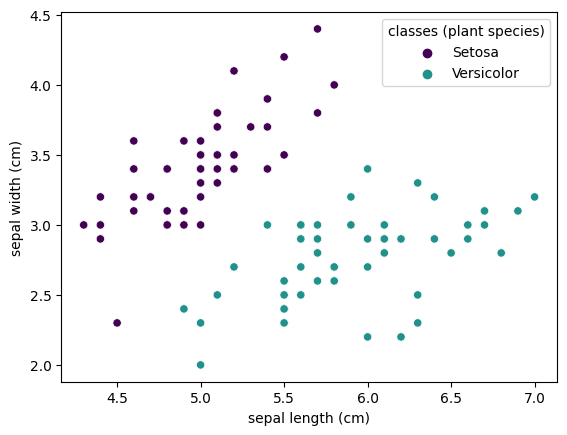

In [ ]:
data, classes = datasets.load_iris(return_X_y=True, as_frame=True)

## only keep two of three plant species (Setosa and Versicolour)
keep = np.isin(classes.values, [0,1])
classes = classes.loc[keep]

x = data[keep].iloc[:,:2]

class_index_to_name = {
    0: 'Setosa',
    1: 'Versicolor',
    2: 'Virginica'
}

class_names = classes.map(class_index_to_name)

sns.scatterplot(data=x, x='sepal length (cm)', y='sepal width (cm)', hue=class_names, palette=class_palette)
plt.legend(title='classes (plant species)')

x = x.values
y = classes.values

We can compute a confusion matrix that contains TN, FP, FN, and TP as follows.

In [ ]:
## create training and testing datasets. then, from the training set, create training set and validation set
x_train, x_test, y_train, y_test = \
    train_test_split(x, y, test_size=0.2, random_state=42)

x_train, x_valid, y_train, y_valid = \
    train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [ ]:
knn = KNN(K=5)
dt  = DecisionTree(max_depth=1)

y_test_prob_knn, _ = knn.fit(x_train, y_train).predict(x_test)
y_test_prob_dt     = dt.fit(x_train, y_train).predict(x_test)

y_test_pred_knn = y_test_prob_knn.argmax(-1)
y_test_pred_dt  = y_test_prob_dt.argmax(-1)

In [ ]:
### confusion matrix ###
from sklearn.metrics import confusion_matrix

cm_knn = confusion_matrix(y_test, y_test_pred_knn)
cm_dt  = confusion_matrix(y_test, y_test_pred_dt)

cm_df_knn = pd.DataFrame(cm_knn, index=['Actual Negative','Actual Positive'],
                     columns=['Predicted Negative', 'Predicted Positive'])

cm_df_dt = pd.DataFrame(cm_dt, index=['Actual Negative','Actual Positive'],
                     columns=['Predicted Negative', 'Predicted Positive'])

print('KNN confusion matrix')
print(cm_df_knn)
print()
print('DT confusion matrix')
print(cm_df_dt)

KNN confusion matrix
                 Predicted Negative  Predicted Positive
Actual Negative                  12                   0
Actual Positive                   0                   8

DT confusion matrix
                 Predicted Negative  Predicted Positive
Actual Negative                  10                   2
Actual Positive                   0                   8
